In [39]:
from plot_utils import *
import pandas as pd
import numpy as np
import datetime
import os


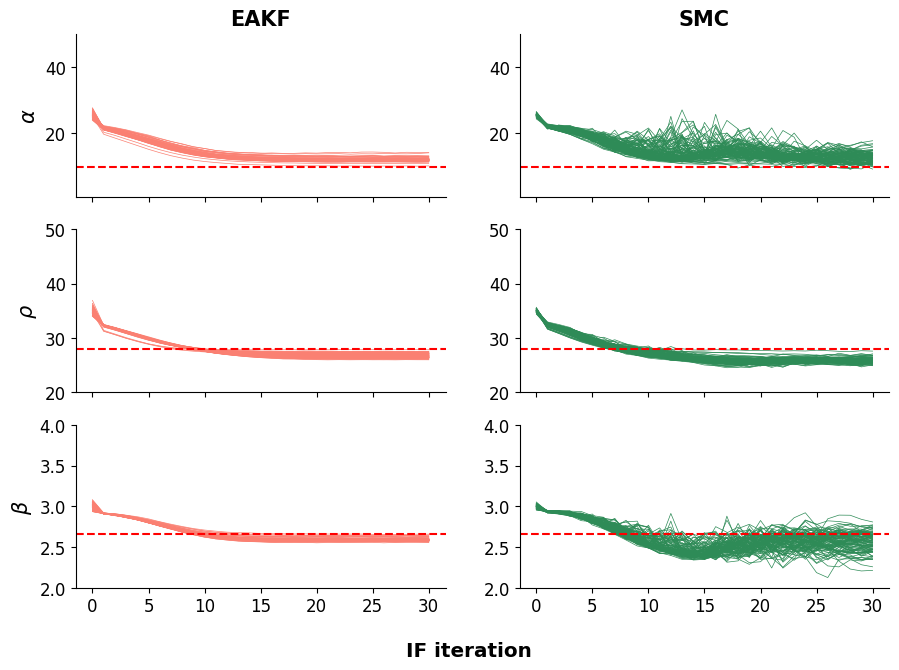

In [40]:
results_dir = 'results'

eakf_dir = os.path.join(results_dir, 'eakf')
pf_dir   = os.path.join(results_dir, 'inference', 'pf')

αmin = 1
αmax = 50

ρmin = 20
ρmax = 50

βmin = 2
βmax = 4
parameters_range  = np.array([[αmin, αmax],
                              [ρmin, ρmax],
                              [βmin, βmax]])
θ_truth = [10, 28, 8/3]

fig, ax = plt.subplots(3, 2, figsize=(10.5, 7.2), sharex=True)

for i in range(0, 99+1):

    i_file     = str(i).zfill(3)
    infer_file = os.path.join(eakf_dir, '{}_infer.npz'.format(i_file))

    infer = np.load(infer_file)
    θmle  = infer['θmle']

    ax[0, 0].plot(range(30+1), θmle[0, :], label='True', color="salmon", lw=0.5)
    ax[1, 0].plot(range(30+1), θmle[1, :], label='True', color="salmon", lw=0.5)
    ax[2, 0].plot(range(30+1), θmle[2, :], label='True', color="salmon", lw=0.5)

    infer_file = os.path.join(pf_dir, '{}_infer.npz'.format(i_file))
    infer = np.load(infer_file)
    θmle  = infer['θmle']

    ax[0, 1].plot(range(30+1), θmle[0, :], label='True', color="seagreen", lw=0.5)
    ax[1, 1].plot(range(30+1), θmle[1, :], label='True', color="seagreen", lw=0.5)
    ax[2, 1].plot(range(30+1), θmle[2, :], label='True', color="seagreen", lw=0.5)

p_label = ['α', 'ρ', 'β']
for p in range(3):
    ax[p,0].axhline(y=θ_truth[p], color='red', ls='--')
    ax[p,0].set_ylim(parameters_range[p])
    ax[p,1].axhline(y=θ_truth[p], color='red', ls='--')
    ax[p,1].set_ylim(parameters_range[p])

    ax[p, 0].set_ylabel(r'${}$'.format(p_label[p]))

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

ax[0, 0].set_title('EAKF', weight="bold", fontsize=15)
ax[0, 1].set_title('SMC', weight="bold", fontsize=15)

fig.supxlabel("IF iteration", weight='bold')

fig.savefig('figures/convergence_mean.png', dpi=300, bbox_inches='tight', transparent=True)

In [41]:
all_df = []

for i in range(1, 99+1):

    i_file     = str(i).zfill(3)
    infer_file = os.path.join(eakf_dir, '{}_infer.npz'.format(i_file))

    infer = np.load(infer_file)
    θpost = infer["θpost"][:,:,-1]

    df = pd.DataFrame.from_dict({'α': θpost[0,:], 'ρ': θpost[1,:], 'β': θpost[2,:], "idx": [i]*θpost.shape[1]}, orient='index').T
    df["method"] = "EAKF"
    df["ens_id"] = np.arange(θpost.shape[1])
    all_df.append(df)

    infer_file = os.path.join(pf_dir, '{}_infer.npz'.format(i_file))
    infer = np.load(infer_file)
    θpost = infer["θpost"][:,:,-1]

    df = pd.DataFrame.from_dict({'α': θpost[0,:], 'ρ': θpost[1,:], 'β': θpost[2,:],"idx": [i]*θpost.shape[1]}, orient='index').T
    df["method"] = "PF"
    df["ens_id"] = np.arange(θpost.shape[1])
    all_df.append(df)

    #mle_df = mle_df.append({'α': θmle[0], 'ρ': θmle[1], 'β': θmle[2], "method": "PF"}, ignore_index=True)
mle_df = pd.concat(all_df)
mle_df = mle_df.sort_values(by=['method', "idx"])

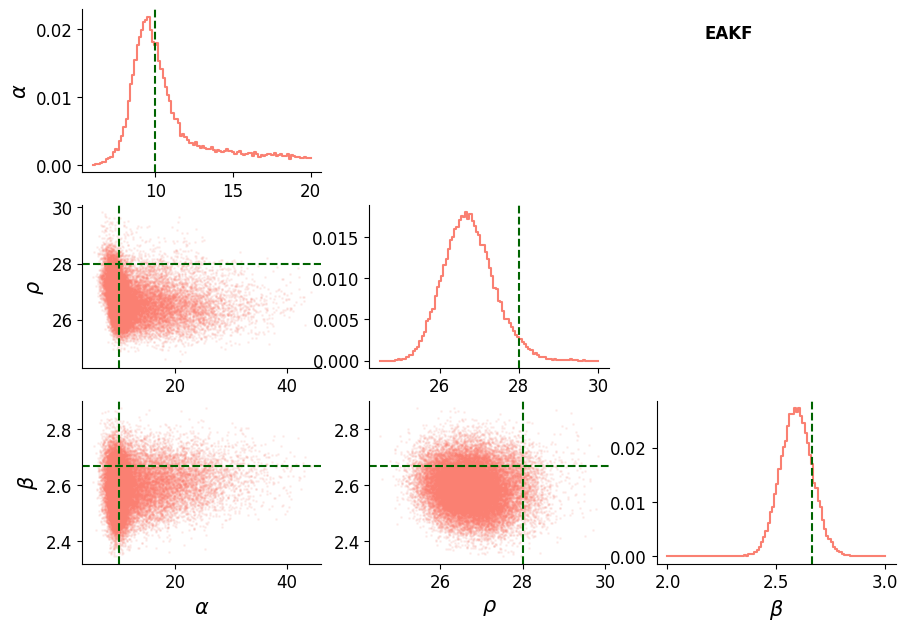

In [44]:
from scipy.ndimage import gaussian_filter


p_range = [ (6 , 20), (24.5, 30), (2, 3)]

cols = ['α', 'ρ', 'β']

fig, ax = plt.subplots(3, 3, figsize=(10.5, 7.2), sharex=False, sharey=False)

for p in range(3):
    eakf_df = mle_df[mle_df['method'] == 'EAKF']
    pf_df   = mle_df[mle_df['method'] == 'PF']

    bins_1d = np.linspace(p_range[p][0], p_range[p][1],  100+1)
    x, _    = np.histogram(eakf_df[cols[p]].values, bins=bins_1d)

    x0 = np.array(list(zip(bins_1d[:-1], bins_1d[1:]))).flatten()
    y0 = np.array(list(zip(x, x))).flatten()
    ax[p, p].plot(x0, y0/np.sum(y0), color="salmon")
    ax[p, p].axvline(x=θ_truth[p], color='darkgreen', ls='--')

for p in range(3):
    ax[p, 0].set_ylabel(r'${}$'.format(cols[p]))
    ax[-1, p].set_xlabel(r'${}$'.format(cols[p]))

for pi in range(3):
    for pj in range(3):
        if pi>pj:
            p1_df = eakf_df[[cols[pi], cols[pj], "idx"]]
            ax[pi, pj].scatter(p1_df[cols[pj]], p1_df[cols[pi]], color="salmon", s=1, alpha=0.1)

            ax[pi, pj].axhline(y=θ_truth[pi], color='darkgreen', ls='--')
            ax[pi, pj].axvline(x=θ_truth[pj], color='darkgreen', ls='--')

        elif pi<pj:
            ax[pi, pj].remove()

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
ax[0, 0].text(2.7, 0.85, 'EAKF', horizontalalignment='center',
              verticalalignment='center', transform=ax[0, 0].transAxes, weight='bold')

fig.savefig('figures/corner_eakf.png', dpi=300, bbox_inches='tight', transparent=True)

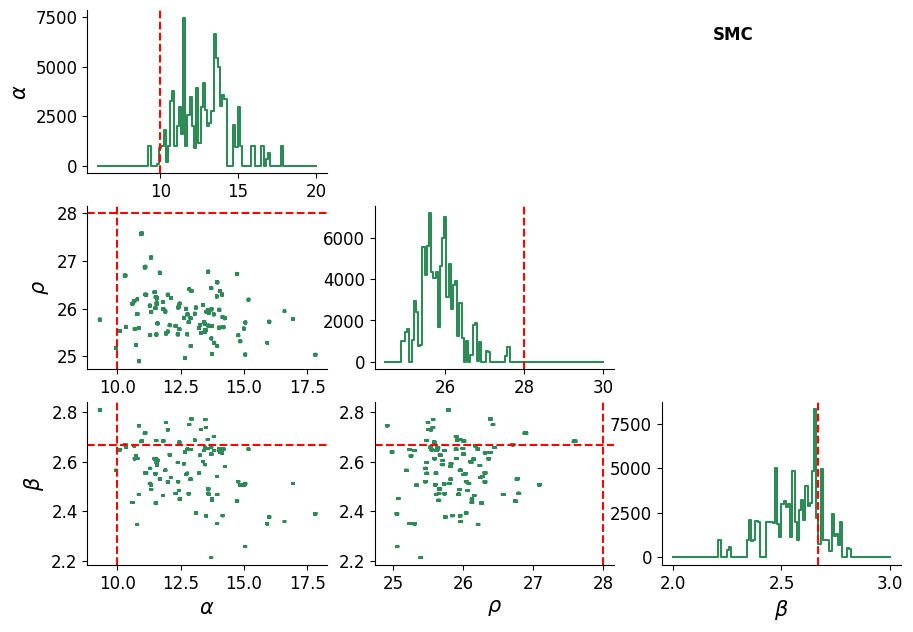

In [45]:
from scipy.ndimage import gaussian_filter

p_range = [ (6 , 20), (24.5, 30), (2, 3)]

cols = ['α', 'ρ', 'β']

fig, ax = plt.subplots(3, 3, figsize=(10.5, 7.2), sharex=False, sharey=False)

for p in range(3):
    eakf_df = mle_df[mle_df['method'] == 'EAKF']
    pf_df   = mle_df[mle_df['method'] == 'PF']


    bins_1d = np.linspace(p_range[p][0], p_range[p][1],  100+1)
    x, _    = np.histogram(pf_df[cols[p]].values, bins=bins_1d)

    x0 = np.array(list(zip(bins_1d[:-1], bins_1d[1:]))).flatten()
    y0 = np.array(list(zip(x, x))).flatten()
    ax[p, p].plot(x0, y0, color="seagreen")
    ax[p, p].axvline(x=θ_truth[p], color='red', ls='--')

for p in range(3):
    ax[p, 0].set_ylabel(r'${}$'.format(cols[p]))
    ax[-1, p].set_xlabel(r'${}$'.format(cols[p]))

for pi in range(3):
    for pj in range(3):
        if pi>pj:
            p1_df = pf_df[[cols[pi], cols[pj], "idx"]]
            ax[pi, pj].scatter(p1_df[cols[pj]], p1_df[cols[pi]], color="seagreen", s=1, alpha=0.1)

            ax[pi, pj].axhline(y=θ_truth[pi], color='red', ls='--')
            ax[pi, pj].axvline(x=θ_truth[pj], color='red', ls='--')

        elif pi<pj:
            ax[pi, pj].remove()

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

ax[0, 0].text(2.7, 0.85, 'SMC', horizontalalignment='center',
              verticalalignment='center', transform=ax[0, 0].transAxes, weight='bold')

fig.savefig('figures/corner_SMC.png', dpi=300, bbox_inches='tight', transparent=True)